In [1]:
# Install dependencies
!pip install timm torchvision matplotlib scikit-learn --quiet

# Step 1: Upload GCS service account key
from google.colab import files
uploaded = files.upload()  # Upload your onion11-key.json here

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.6 MB/s eta 0:00:00


Saving static-destiny-459808-m8-6237faecf4a5.json to static-destiny-459808-m8-6237faecf4a5.json


In [2]:
# Step 2: Setup environment and download from GCS
import os
json_key = list(uploaded.keys())[0]
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = json_key
!gcloud auth activate-service-account --key-file="$GOOGLE_APPLICATION_CREDENTIALS"

# Replace with your actual GCS path
GCS_PATH = "gs://onion11"
!mkdir -p OnionData
!gsutil -m cp -r "$GCS_PATH"/* OnionData/

Streaming output truncated to the last 5000 lines.
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0

In [4]:
# Step 3: Organize dataset into train/val/test (similar to CoatNet code)
import shutil, random

def prepare_onion_dataset(base_dir='OnionData'):
    from collections import defaultdict
    import os, shutil, random

    class_map = {}
    txt_path = os.path.join(base_dir, "classes.txt")
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            for i, line in enumerate(f):
                class_map[str(i)] = line.strip()

    jpgs = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith(".jpg")}
    txts = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith(".txt")}
    paired = [k for k in jpgs if k in txts]

    class_to_images = defaultdict(list)
    for k in paired:
        txt_file_path = os.path.join(base_dir, txts[k])
        try:
            with open(txt_file_path, 'r') as f:
                line = f.readline().strip()
                if not line:
                    print(f"⚠️ Skipping empty label file: {txt_file_path}")
                    continue
                tokens = line.split()
                if len(tokens) == 0:
                    print(f"⚠️ No tokens in line: {txt_file_path}")
                    continue
                cls_id = tokens[0]
                label = class_map.get(cls_id, f"class_{cls_id}")
                class_to_images[label].append(jpgs[k])
        except Exception as e:
            print(f"❌ Error processing {txt_file_path}: {e}")

    # Create train/val/test directories
    for split in ['train', 'val', 'test']:
        for cls in class_to_images:
            os.makedirs(os.path.join(split, cls), exist_ok=True)

    # Copy files into respective folders
    for cls, files in class_to_images.items():
        random.shuffle(files)
        n = len(files)
        n_train, n_val = int(0.8 * n), int(0.1 * n)
        for i, f in enumerate(files):
            if i < n_train:
                dest = 'train'
            elif i < n_train + n_val:
                dest = 'val'
            else:
                dest = 'test'
            shutil.copyfile(os.path.join(base_dir, f), os.path.join(dest, cls, f))

prepare_onion_dataset()

⚠️ Skipping empty label file: OnionData/Th_I__B1_IMG20230207093540_FEB_8.txt


In [5]:
# Step 4: PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Step 5: Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder("train", transform=transform)
val_data = datasets.ImageFolder("val", transform=transform)
test_data = datasets.ImageFolder("test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
num_classes = len(class_names)

In [13]:
# Step 6: Load Swin Transformer Model
from timm import create_model

# ✅ Load Swin Transformer with global average pooling for correct output shape
model = create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=True,
    num_classes=num_classes,
    global_pool='avg'  # ✅ Ensures output shape is [B, C]
)

model.to(device)

# ✅ Freeze all layers except classification head
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

In [14]:
# Step 7: Train

start = time.time()
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss, correct = 0.0, 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)

        # 🛠 Ensure labels are in correct shape: [batch_size]
        if labels.ndim > 1:
            labels = torch.argmax(labels, dim=1)

        labels = labels.long().to(device)

        # 👇 Uncomment this once to debug the shapes
        # print(f"[DEBUG] outputs shape: {model(images).shape}, labels shape: {labels.shape}")

        optimizer.zero_grad()
        outputs = model(images)

        # Ensure outputs is [batch_size, num_classes] and labels is [batch_size]
        if outputs.ndim != 2 or labels.ndim != 1:
            raise ValueError(f"❌ Shape mismatch: outputs shape {outputs.shape}, labels shape {labels.shape}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_loader.dataset)
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accs.append(train_acc)

    # Validation loop
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            if labels.ndim > 1:
                labels = torch.argmax(labels, dim=1)
            labels = labels.long().to(device)

            outputs = model(images)

            if outputs.ndim != 2 or labels.ndim != 1:
                raise ValueError(f"❌ VAL Shape mismatch: outputs shape {outputs.shape}, labels shape {labels.shape}")

            val_loss += criterion(outputs, labels).item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss / len(val_loader.dataset))
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


end = time.time()
training_time = end - start

Epoch 1/10 | Train Acc: 0.2552 | Val Acc: 0.5189
Epoch 2/10 | Train Acc: 0.5566 | Val Acc: 0.6792
Epoch 3/10 | Train Acc: 0.6859 | Val Acc: 0.7264
Epoch 4/10 | Train Acc: 0.7344 | Val Acc: 0.7736
Epoch 5/10 | Train Acc: 0.7379 | Val Acc: 0.7830
Epoch 6/10 | Train Acc: 0.7494 | Val Acc: 0.7925
Epoch 7/10 | Train Acc: 0.7564 | Val Acc: 0.8019
Epoch 8/10 | Train Acc: 0.7494 | Val Acc: 0.8019
Epoch 9/10 | Train Acc: 0.7633 | Val Acc: 0.8019
Epoch 10/10 | Train Acc: 0.7771 | Val Acc: 0.8019


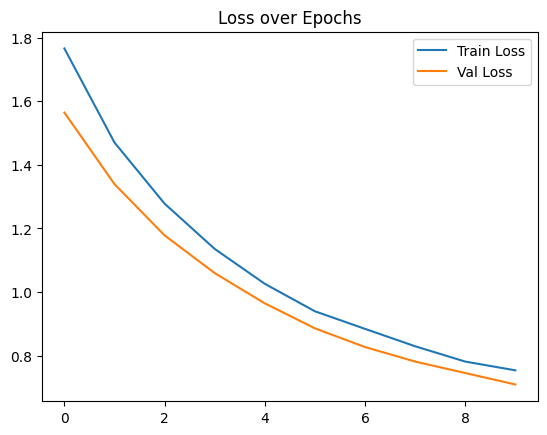

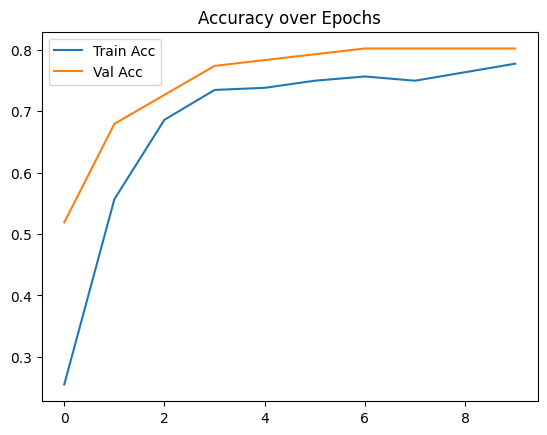

In [15]:
# Step 8: Plot Loss and Accuracy
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

In [16]:
# Step 9: Evaluate on Test Set
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        if labels.ndim > 1:
            labels = torch.argmax(labels, dim=1)
        labels = labels.long()

        outputs = model(images)
        y_probs.extend(outputs.cpu().numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())

test_accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")


✅ Test Accuracy: 76.11%



📊 Classification Report:
                        precision    recall  f1-score   support

           Anthracnose       0.73      0.77      0.75        31
             Basal_Rot       0.00      0.00      0.00         2
Iris_Yellow_Spot_Virus       0.92      0.96      0.94        25
         Purple_Blotch       0.20      0.10      0.13        10
    Stemphylium_Blight       0.53      0.53      0.53        15
                Thrips       0.85      0.97      0.91        30

              accuracy                           0.76       113
             macro avg       0.54      0.56      0.54       113
          weighted avg       0.72      0.76      0.74       113



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


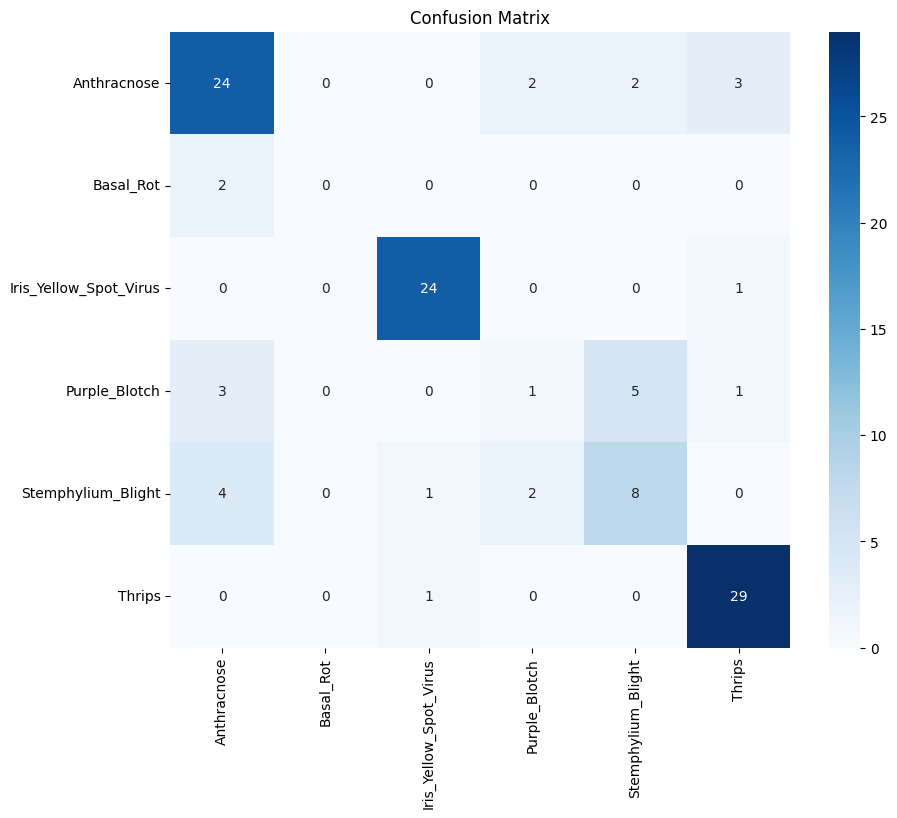

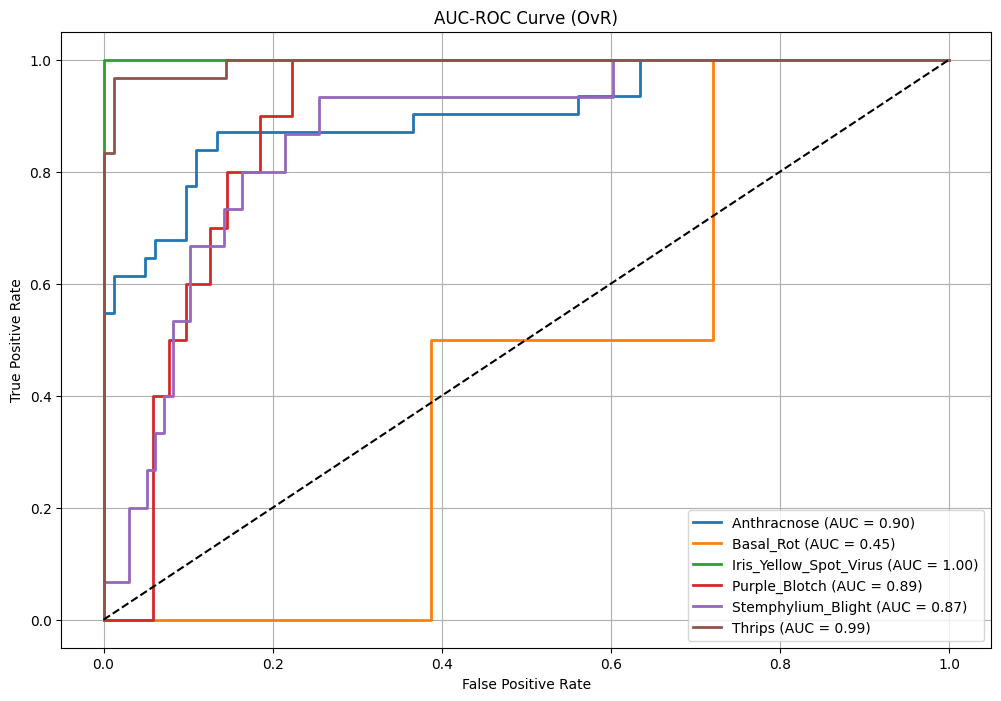

🧮 Macro AUC: 0.8504
🧮 Weighted AUC: 0.9349

⏱️ Training Time: 1893.97 seconds
📦 Model Size: 105.00 MB
✅ Final Train Accuracy: 77.71%
✅ Final Val Accuracy: 80.19%


In [17]:
# Step 10: Report, Confusion Matrix, AUC-ROC
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
y_probs = np.array(y_probs)

plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve (OvR)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

print(f"🧮 Macro AUC: {roc_auc_score(y_true_bin, y_probs, average='macro'):.4f}")
print(f"🧮 Weighted AUC: {roc_auc_score(y_true_bin, y_probs, average='weighted'):.4f}")

# Step 11: Model Size & Summary
model_size_MB = sum(p.numel() for p in model.parameters()) * 4 / (1024 ** 2)
print(f"\n⏱️ Training Time: {training_time:.2f} seconds")
print(f"📦 Model Size: {model_size_MB:.2f} MB")
print(f"✅ Final Train Accuracy: {train_accs[-1] * 100:.2f}%")
print(f"✅ Final Val Accuracy: {val_accs[-1] * 100:.2f}%")